In [10]:
#Modified from https://github.com/choldgraf/write-ups/blob/master/comp/craigslist_scrape.ipynb
import pandas as pd
from time import sleep
import numpy as np
import requests
from bs4 import BeautifulSoup as bs4
import seaborn as sns

%matplotlib inline

In [9]:
loc_prefixes = ['sfc']
#loc_prefixes = ['eby', 'nby', 'sfc', 'sby', 'scz']


In [3]:
def find_prices(results):
    prices = []
    for rw in results:
        price = rw.find('span', {'class': 'price'})
        if price is not None:
            price = float(price.text.strip('$'))
        else:
            price = np.nan
        prices.append(price)
    return prices

# no addresses in search results only in post page itself
def find_address(results):
    address = []
    for rw in results:
        address = rw.find()
        if time is not None:
            time = time['datetime']
            time = pd.to_datetime(time)
        else:
            time = np.nan
        times.append(time)
    return times

In [24]:
def find_size_and_brs(size):
    split = size.strip('/- ').split(' - ')
    if len(split) == 2:
        n_brs = split[0].replace('br', '')
        this_size = split[1].replace('ft2', '')
    elif 'br' in split[0]:
        # It's the n_bedrooms
        n_brs = split[0].replace('br', '')
        this_size = -1
    elif 'ft2' in split[0]:
        # It's the size
        this_size = split[0].replace('ft2', '')
        n_brs = -1
    return float(this_size), float(n_brs)


In [6]:
results = []  # We'll store the data here
# Careful with this...too many queries == your IP gets banned temporarily
search_indices = np.arange(0, 300, 100)

In [31]:
def crawl_cl(pr, br, ba, radius=1, postal=94103):

    # Now loop through all of this and store the results
    results = []  # We'll store the data here

    #search_indices = np.arange(0, 300, 100)
    for loc in loc_prefixes:
        print(loc)
        for i in range(0,5):
            #print(i)
            url = 'http://sfbay.craigslist.org/search/{0}/apa'.format(loc)
            # 1 mile radius from soma/civic center
            resp = requests.get(url, params={'bedrooms': br, 'max_price':pr, 'bathrooms':ba, \
                                             'search_distance': radius, 'postal':postal, 's': i})
            #print(resp.url)
            txt = bs4(resp.text, 'html.parser')
            apts = txt.findAll(attrs={'class': "row"})
            #print(apts)
            # Find the size of all entries
            size_text = [rw.findAll(attrs={'class': 'housing'})[0].text
                         for rw in apts]
            #print(size_text)
            sizes_brs = [find_size_and_brs(stxt) for stxt in size_text]
            #print(sizes_brs)
            sizes, n_brs = zip(*sizes_brs)  # This unzips into 2 vectors

            # Find the title and link
            title = [rw.find('a', attrs={'class': 'hdrlnk'}).text
                          for rw in apts]
            links = ['https://sfbay.craigslist.org'+rw.find('a', attrs={'class': 'hdrlnk'})['href']
                     for rw in apts]

            hood = [rw.find('span', {'class': 'pnr'}).text.split('   ')[0][3:-1] for rw in apts]
            # Find the time
            time = [pd.to_datetime(rw.find('time')['datetime']) for rw in apts]
            price = find_prices(apts)

            #create price per sq ft
            pricepersqft = [price[a]/sizes[a] for a in range(0,len(price))]

            # We'll create a dataframe to store all the data
            data = np.array([time, price, sizes, pricepersqft, n_brs, title, hood, links])
            col_names = ['time', 'price', 'size', 'pricepersqft','brs', 'title', 'neighborhood', 'link']
            df = pd.DataFrame(data.T, columns=col_names)
            df = df.set_index('time')

            # Add the location variable to all entries
            #df['loc'] = loc
            results.append(df)
            #sleep 30 seconds
            sleep_amt = np.random.randint(20, 60)
            sleep(sleep_amt)
    # Finally, concatenate all the results
    results = pd.concat(results, axis=0)
    return results

In [32]:
results = crawl_cl(3500, 1, 1)

sfc


In [33]:
results = results[results['brs']==1].drop_duplicates() #only looking for 1 bedrooms

In [34]:
results.describe()

,price,size,pricepersqft,brs,title,neighborhood,link
count,81.0,81.0,81.0,81.0,81,81,81
unique,41.0,25.0,54.0,1.0,71,10,81
top,2495.0,-1.0,-2495.0,1.0,"Remodeled One Bedroom, Hardwood Flrs, Heart of the Lower Haight",SOMA / south beach,https://sfbay.craigslist.org/sfc/apa/5575284365.html
freq,6.0,49.0,6.0,81.0,4,26,1


In [35]:
withsqft = results[results['pricepersqft']>0]

In [36]:
pd.set_option('max_colwidth',100)

In [37]:
withsqft.sort_values(['pricepersqft'], ascending=True)

,price,size,pricepersqft,brs,title,neighborhood,link
time,,,,,,,
2016-05-09 23:02:00,2000,882,2.26757,1,1 Bed/bath Suite in Modern Complex w/ Gym,downtown / civic / van ness,https://sfbay.craigslist.org/sfc/apa/5578787769.html
2016-05-10 12:02:00,3400,1000,3.4,1,"SOMA, LIGHT FILLED Loft Near Twitter - $3400",SOMA / south beach,https://sfbay.craigslist.org/sfc/apa/5579645550.html
2016-05-10 07:10:00,2450,700,3.5,1,Large 1 Bedroom Flat available for SoMa summer sublet,SOMA / south beach,https://sfbay.craigslist.org/sfc/apa/5568387176.html
2016-05-09 13:41:00,2833,780,3.63205,1,2 MONTHS FREE RENT! BARGAIN PRICE! MOVE-IN READY 1BD/1.5BA,SOMA / south beach,https://sfbay.craigslist.org/sfc/apa/5570500101.html
2016-05-09 13:46:00,2833,780,3.63205,1,2 MONTHS FREE RENT! BARGAIN PRICE! MOVE-IN READY 1BD/1.5BA,SOMA / south beach,https://sfbay.craigslist.org/sfc/apa/5578127033.html
2016-05-10 11:47:00,3500,950,3.68421,1,Beautiful furnished apartment in Haight- Buena Vista Park,San Francisco,https://sfbay.craigslist.org/sfc/apa/5579591985.html
2016-05-09 17:54:00,2695,689,3.91147,1,THE SECRET GARDEN APARTMENTS!1BR you can make into a 2BR to share,tenderloin,https://sfbay.craigslist.org/sfc/apa/5578512616.html
2016-05-09 18:35:00,3147,769,4.09233,1,Polk St 1 bedroom with amazing Walk In Closet! Today Only!,downtown / civic / van ness,https://sfbay.craigslist.org/sfc/apa/5578555056.html
2016-05-09 15:57:00,3406,814,4.18428,1,Looking To Move? Come See Our Open Floor Plans!,downtown / civic / van ness,https://sfbay.craigslist.org/sfc/apa/5578325404.html


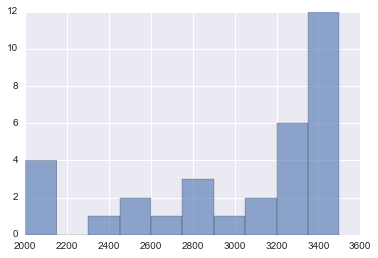

In [38]:
withsqft.price.hist(alpha=.6)

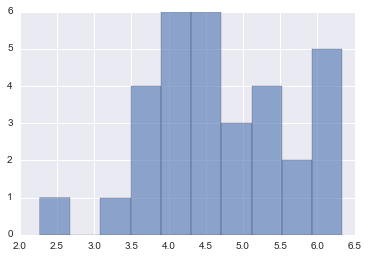

In [39]:
withsqft.pricepersqft.hist(alpha=.6)

In [40]:
withoutsqft = results[results['pricepersqft']<0]

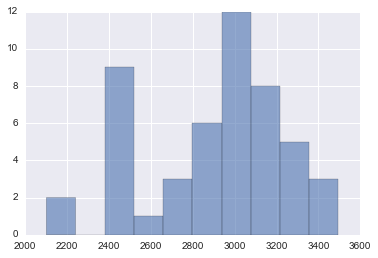

In [41]:
withoutsqft.price.hist(alpha=.6)

In [ ]:
withoutsqft.sort_values(['price'], ascending=True)

In [43]:
withsqft.to_csv('with.csv')
withoutsqft.to_csv('without.csv')